In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score


import time

# Any results you write to the current directory are saved as output.

In [2]:
df_train = pd.read_csv('titanic.csv')
Y = df_train['Survived']

In [3]:
df_test = df_train[:200]
df_train = df_train[0:691]

## Overview

In [4]:
df_train[:10]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## Histograms

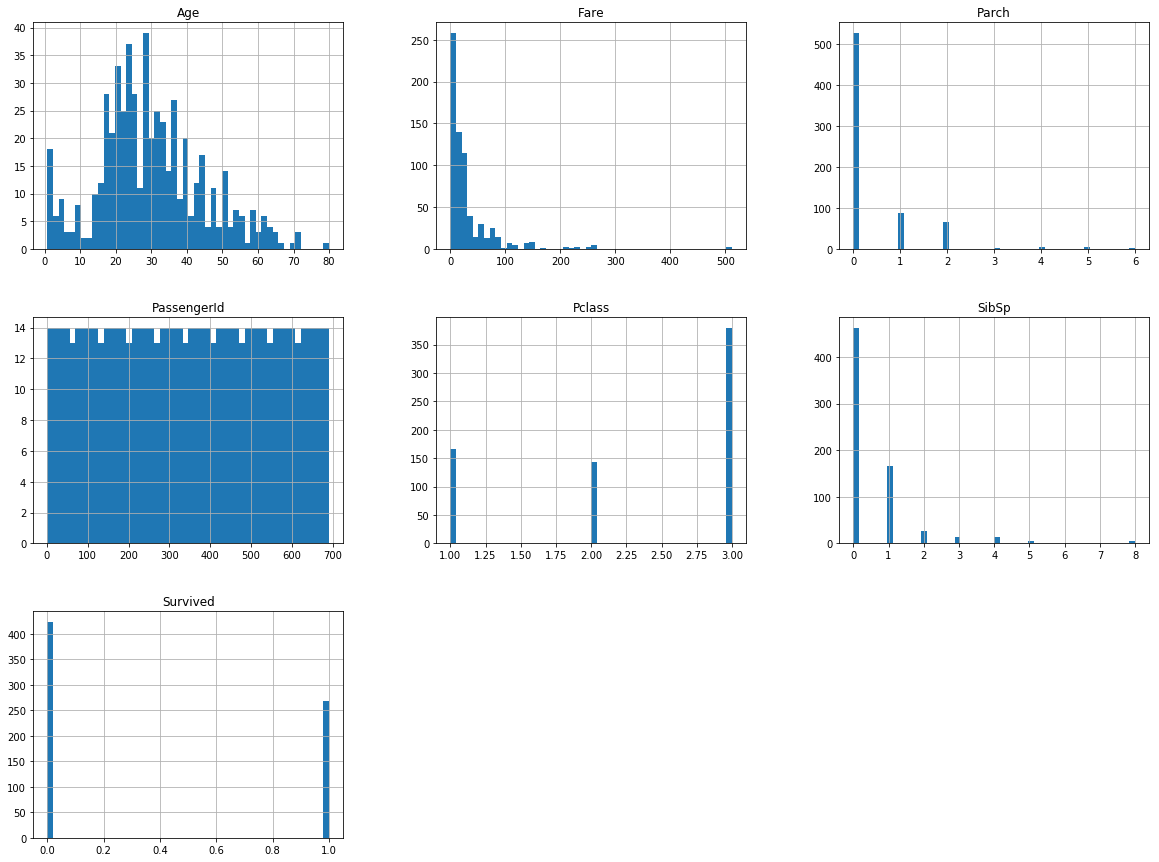

In [5]:
df_train.hist(bins=50, figsize=(20, 15))
plt.show()

## Information on columns

In [6]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,691.000000,691.000000,691.000000,548.000000,691.000000,691.000000,691.000000
mean,346.000000,0.387844,2.308249,29.921989,0.538350,0.387844,32.276103
std,199.618803,0.487612,0.835224,14.598391,1.076585,0.821855,48.447543
min,1.000000,0.000000,1.000000,0.750000,0.000000,0.000000,0.000000
25%,173.500000,0.000000,2.000000,21.000000,0.000000,0.000000,7.925000
50%,346.000000,0.000000,3.000000,28.000000,0.000000,0.000000,15.000000
75%,518.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.275000
max,691.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Build of my Transformers

In [7]:
#Custom Transformer which drop colunmns
from sklearn.base import TransformerMixin
class DropTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cat=['Ticket', 'Fare', 'Cabin', 'Name', 'SibSp', 'Parch', 'PassengerId']
        Xnew = X.drop(cat, axis=1)
        return Xnew

In [8]:
#Custom Transformer get dummies of my categorical columns
class GetDummiesTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        features_totransform = ['Sex', 'Embarked', 'Pclass', 'Title']
        for var in features_totransform:
            X = pd.concat([X.drop(var, axis=1), pd.get_dummies(X[var], prefix=var)], axis=1)
        return X

In [9]:
#Custom Transformer for impute median age into NaN values
class Imputer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Age'] = X['Age'].fillna(df_train['Age'].median())
        return X


In [10]:
#Custom Transformer for extract Title of people
class Title(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for i in X:
            X['Title']=X['Name'].str.extract('([A-Za-z]+)\.', expand=False)  # Use REGEX to define a search pattern
        return X

In [11]:
#Custom Transformer obtains the number of person of the same family
class Family(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for i in X:
            X['Family']=X['SibSp'] + X['Parch']
        return X

## My Pipelines

In [12]:
#Pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline([ 
        ('imp', Imputer()),
        ('title', Title()),
        ('family', Family()),
        ('drop', DropTransformer()),
        ('encoder', GetDummiesTransformer())
    ])

df_train_tr = pipeline.fit_transform(df_train)
df_test_tr = pipeline.transform(df_test)



df_train_tr contrains 28 columns wheareas df_test_tr contains only 19 columns..

A lot of Titles are not given

In [13]:
#Custom Transformer for modify the Title into other caterogies
class TitleTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for i in X:
            X['Title']=X['Title'].replace(['Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev'], 'Officer')
            X['Title']=X['Title'].replace(['Lady', 'Countess', 'Sir', 'Jonkheer', 'Dona', 'Master'], 'Royalty')
            X['Title']=X['Title'].replace('Mlle', 'Miss')
            X['Title'] = X['Title'].replace('Ms', 'Miss')
            X['Title'] = X['Title'].replace('Mme', 'Mrs')
            
        return X


In [14]:
#Pipeline
from sklearn.pipeline import Pipeline
pipeline2= Pipeline([ 
        ('imp', Imputer()),
        ('title', Title()),
        ('family', Family()),
        ('drop', DropTransformer()),
        ('titlet', TitleTransformer()),
        ('encoder', GetDummiesTransformer())
    ])

df_train_tr = pipeline2.fit_transform(df_train)
df_test_tr = pipeline2.transform(df_test)

## Classifier

In [15]:
from sklearn.model_selection import GridSearchCV

X_train = df_train_tr.drop(['Survived'], axis=1).values
X_test = df_test_tr.drop(['Survived'], axis=1).values
y_train_1 = (df_train['Survived'] == 1)
y_test_1 = (df_test['Survived'] ==1)

### SVM

In [25]:
from sklearn.svm import SVC

start_time = time.time()


SVM = SVC(probability=True)
SVM.fit(X_train, y_train_1)
y_scores_svm = SVM.predict(X_test)

y_probas_SVM_train = cross_val_predict(SVM, X_train, y_train_1, cv=3,
                             method="predict_proba")
y_scores_SVM_train = y_probas_SVM_train[:, 1] # score = proba of positive class

result_SVM = accuracy_score(y_test_1, y_scores_svm)
print(result_SVM)
svm_time = (time.time() - start_time)



C:\Users\Anthime\Anaconda3\envs\myfirstenv\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Anthime\Anaconda3\envs\myfirstenv\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Anthime\Anaconda3\envs\myfirstenv\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Anthime\Anaconda

0.86


0.23300743103027344

### Decision Tree

In [29]:

DTC = DecisionTreeClassifier(criterion='gini', max_depth=10)

start_time = time.time()

DTC.fit(X_train, y_train_1)
y_scores_DTC = DTC.predict(X_test)
y_probas_DTC_train = cross_val_predict(DTC, X_train, y_train_1, cv=3,
                             method="predict_proba")
y_scores_DTC_train = y_probas_DTC_train[:, 1] # score = proba of positive class


result_DTC = accuracy_score(y_test_1, y_scores_DTC)
print(result_DTC)
DTC_time = (time.time() - start_time)
print(DTC_time)

0.915
0.010935306549072266


### RandomForest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

start_time = time.time()


forest_clf.fit(X_train, y_train_1)
y_scores_forest = forest_clf.predict(X_test)

y_probas_forest_train = cross_val_predict(forest_clf, X_train, y_train_1, cv=3,
                             method="predict_proba")
y_scores_forest_train = y_probas_forest_train[:, 1] # score = proba of positive class

result_forest = accuracy_score(y_test_1, y_scores_forest)
print(result_forest)
forest_time = (time.time() - start_time)

0.92


C:\Users\Anthime\Anaconda3\envs\myfirstenv\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### AdaBoostClassifier


In [19]:
from sklearn.ensemble import AdaBoostClassifier


DTC = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(DTC, random_state=42)


In [31]:
start_time = time.time()

ada_clf.fit(X_train, y_train_1)
y_scores_ada = ada_clf.predict(X_test)
y_scores_ada_train = cross_val_predict(ada_clf, X_train, y_train_1, cv=3,
                             method="decision_function")

result_ada = accuracy_score(y_test_1, y_scores_ada)
print(result_ada)
ada_time = (time.time() - start_time)


0.95


### Voting

In [37]:

from sklearn.ensemble import VotingClassifier
eclf1 = VotingClassifier(estimators=[('svm', SVM),
        ('lr', forest_clf), ('adb', ada_clf), ('dtc', DTC)], voting='soft')
start_time = time.time()

eclf1 = eclf1.fit(X_train, y_train_1)

y_scores_eclf1 =eclf1.predict(X_test)
y_probas_eclf1_train = cross_val_predict(eclf1, X_train, y_train_1, cv=3,
                             method="predict_proba")
y_scores_eclf1_train = y_probas_eclf1_train[:, 1]

result_eclf1 = accuracy_score(y_test_1, y_scores_eclf1)
print(result_eclf1)
eclf1_time = (time.time() - start_time)


C:\Users\Anthime\Anaconda3\envs\myfirstenv\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Anthime\Anaconda3\envs\myfirstenv\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Anthime\Anaconda3\envs\myfirstenv\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.94


C:\Users\Anthime\Anaconda3\envs\myfirstenv\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


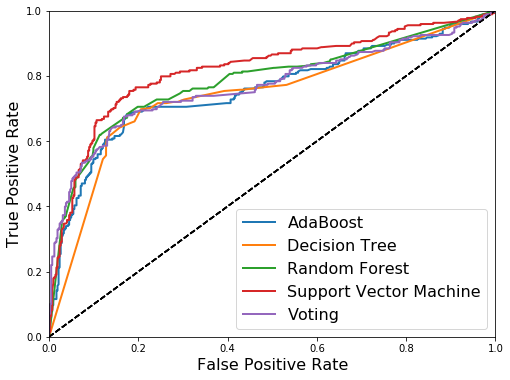

In [22]:

fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_train_1, y_scores_ada_train)
fpr_DTC, tpr_DTC, thresholds_DTC = roc_curve(y_train_1, y_scores_DTC_train)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_1, y_scores_forest_train)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_train_1, y_scores_SVM_train)
fpr_eclf1, tpr_eclf1, thresholds_eclf1 = roc_curve(y_train_1, y_scores_eclf1_train)





def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
    plt.legend(loc="lower right", fontsize=16)


plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_ada, tpr_ada, "AdaBoost")
plot_roc_curve(fpr_DTC, tpr_DTC, "Decision Tree")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_svm, tpr_svm, "Support Vector Machine")
plot_roc_curve(fpr_eclf1, tpr_eclf1, "Voting")


plt.show()


In [39]:
from sklearn.metrics import roc_auc_score

print('Area Under Curve :                               Accuracy on Test :')
print('AUC AdaBoost : ', roc_auc_score(y_train_1, y_scores_ada_train), '               Result on test : ', result_ada)
print('AUC Decision Tree : ', roc_auc_score(y_train_1, y_scores_DTC_train), '          Result on test : ', result_DTC)
print('AUC Forest : ', roc_auc_score(y_train_1, y_scores_forest_train), '                Result on test : ', result_forest)
print('AUC SVM : ', roc_auc_score(y_train_1, y_scores_SVM_train), '                   Result on test : ', result_SVM)
print('AUC Voting : ', roc_auc_score(y_train_1, y_scores_eclf1_train), '                Result on test : ', result_eclf1)


print('\nExecution time')
print('AdaBoost time : ', ada_time)
print('Decision Tree time : ', DTC_time)
print('SVM time : ', svm_time)
print('RandomForest time : ', forest_time)
print('Vote time : ', eclf1_time)

Area Under Curve :                               Accuracy on Test :
AUC AdaBoost :  0.757669983416252                Result on test :  0.95
AUC Decision Tree :  0.732565011820331           Result on test :  0.915
AUC Forest :  0.7849008503581385                 Result on test :  0.92
AUC SVM :  0.8209616809569176                    Result on test :  0.86
AUC Voting :  0.7955832539430507                 Result on test :  0.94

Execution time
AdaBoost time :  0.36901211738586426
Decision Tree time :  0.010935306549072266
SVM time :  0.010974884033203125
RandomForest time :  0.06585502624511719
Vote time :  0.66422438621521
